# Forecast families: how to generate and visualize them.
Use this notebook to generate and visualize forecast families, as introduced in the following paper submitted to Journal of Water Resources Planning and Management:
C. Rougé, A. Peñuela, F. Pianosi. Forecast families: a new method to systematically evaluate the benefits of improving the skill of an existing forecast.

Note the code is demonstrated directly on the bias corrected rainfall forecast (hindcast) for the 1 November 2011, and contained in file `data/example/ECMWF_bias_corr_20111101.csv`.

More forecast data, and the methodology to bias correct these forecasts, is available with the iRONS toolbox at the address `https://github.com/iRONStoolbox/iRONStoolbox` (see also Peñuela et al., 2021 at doi:10.1016/j.envsoft.2021.105188). 

This is also where we start, by importing the climate data corresponding to the forecast.

First, all external library imports.

In [1]:
import pandas as pd
import numpy as np
import os
from dataclasses import make_dataclass

%matplotlib inline

## Part 1: produce a forecast family and visualise it
We use the example forecast contained in file `data/example/ECMWF_bias_corr_20111101.csv`.

### Define the forecast family

In [2]:
# Define the skills: from 0 (benchmark) to 1 (perfect forecast) with 0.2 increments.
# Specifications also used for plotting (skill data frame)
Skill_spec = make_dataclass("Skill_spec", [('value',float), ('stringvalue',str), ('color', str), ('linestyle', str)])
skill_specs = pd.DataFrame([
    Skill_spec(0, str("{:1.1f}".format(0)), 'k', 'solid'),
    Skill_spec(0.2, str("{:1.1f}".format(0.2)), 'k', 'dashed'),
    Skill_spec(0.4, str("{:1.1f}".format(0.4)), 'k', 'dotted'),
    Skill_spec(0.6, str("{:1.1f}".format(0.6)), 'b', 'solid'),
    Skill_spec(0.8, str("{:1.1f}".format(0.8)), 'b', 'dashed'),
    Skill_spec(1, str("{:1.1f}".format(1)), 'b', 'dotted')
])

# Display skill values
print(skill_specs['value'].values)

[0.  0.2 0.4 0.6 0.8 1. ]


### Import weather data
We get that data for the same site (in SW England) as for the paper. We get it from the Github site for iRONS.

In [3]:
# Get the data
url = 'https://github.com/iRONStoolbox/iRONStoolbox/blob/master/iRONS/Notebooks/B%20-%20Implementation/Inputs/hist_clim_data.csv?raw=true'
data = pd.read_csv(url, index_col=0)

# Check it (see printed result below)
print(data.head(5))

# Save it
data.to_csv('data/hist_clim_data.csv')

                 PET       Rain      Temp
Date                                     
01/01/1980  0.166398   0.000000 -0.809513
02/01/1980  0.365613   1.859602 -0.680378
03/01/1980  0.000000  11.534853  2.177372
04/01/1980  0.414094   5.383545  4.559046
05/01/1980  0.215212   1.287237  2.840470


### Prepare weather and forecast data
This includes:
(1) Loading forecast data
(2) Loading observations and formatting them to be consistent with the forecast data (extract right variable, correct range of dates, convert data format).

Here we use the example of precipitation, called 'Rain' in both observation and forecast data.

In [4]:
# Read forecast and make sure date column is read as datetime objects in Pandas.
benchmark_forecast = pd.read_csv('data/example/ECMWF_bias_corr_20111101.csv', index_col=0)
benchmark_forecast.index = pd.to_datetime(np.array(benchmark_forecast.index), format='%Y/%m/%d')

# Read historical data
hist_data = pd.read_csv('data/hist_clim_data.csv', index_col=0)
hist_data.index = pd.to_datetime(np.array(hist_data.index), format='%d/%m/%Y')

# Get the historical data that corresponds to the forecast period
observations = pd.Series(hist_data.loc[benchmark_forecast.index]['Rain'])

# Rainfall is cumulative in the forecast, not in the observations: need for formatting.
observations = observations.cumsum()

### Generate ensemble family

In [5]:
from src.ensemble import generate_family

# Create output folders
if os.path.exists('example_results') is False:
    os.mkdir('example_results')
if os.path.exists('example_results/ensemble_family') is False:
    os.mkdir('example_results/ensemble_family')
    

# Call function to generate family
generate_family(observations=observations, 
                forecast_ensemble=benchmark_forecast, 
                skill_values=skill_specs['value'].values, 
                family_folder='example_results/ensemble_family', 
                different_folders=False, 
                output_filename='Forecast'
               )

### Plot ensemble family
See how the synthetic forecast (red) evolves as skill increases. These panels are identical to those of Figure 3 in the paper.

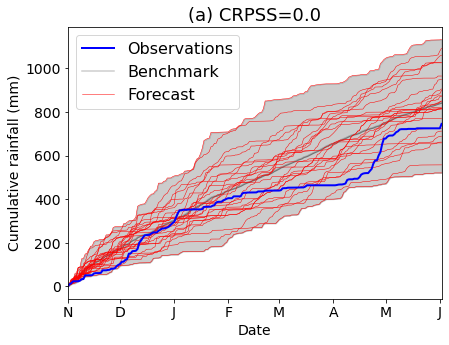

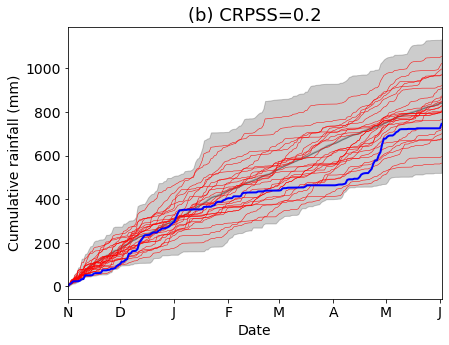

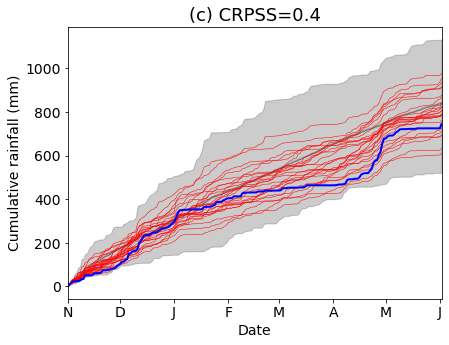

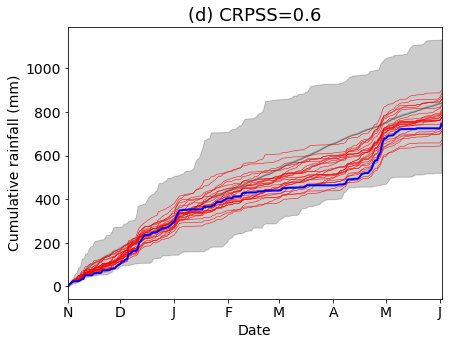

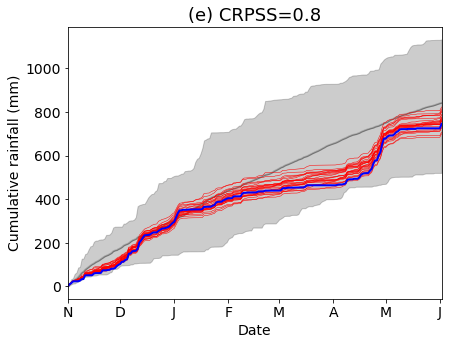

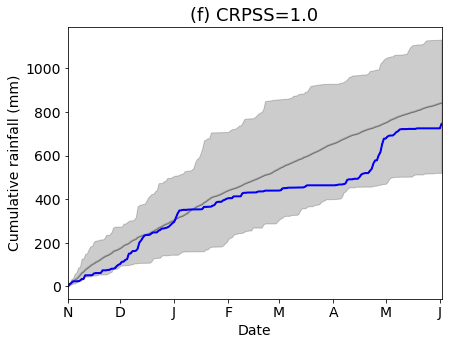

In [6]:
from src.ensemble import plot_family

plot_family(hist_file='data/hist_clim_data.csv',
            forecast_path='data/example/ECMWF_bias_corr_20111101.csv',
            family_path=['example_results/ensemble_family/Forecast_', ''],
            skill_values=skill_specs['value'].values,
            var_name='Rain',
            destination='example_results/ensemble_family/',
            display=True
           )

### Generate deterministic families

First, let's define the deterministic forecast. Here, it will be compute as the ensemble average.

In [7]:
deterministic_benchmark = pd.Series(benchmark_forecast.mean(axis=1))

Now we can generate families, with skill based either on MAE (mean absolute error) or MSE (mean squared error).

In [8]:
from src.deterministic import generate_family

# Create output folder
if os.path.exists('example_results/deterministic_family') is False:
    os.mkdir('example_results/deterministic_family')
    

# Call function to generate both families
family_mae = generate_family(observations=observations, 
                             fore_det=deterministic_benchmark, 
                             skill_values=skill_specs['value'].values, 
                             skill_name='MAE'
                            )
family_mse = generate_family(observations=observations, 
                             fore_det=deterministic_benchmark, 
                             skill_values=skill_specs['value'].values, 
                             skill_name='MSE'
                            )

# Save families
family_mae.to_csv('example_results/deterministic_family/Forecast_mae.csv')
family_mse.to_csv('example_results/deterministic_family/Forecast_mse.csv')

### Plot deterministic families

These panels are identical to those in the paper's appendix.

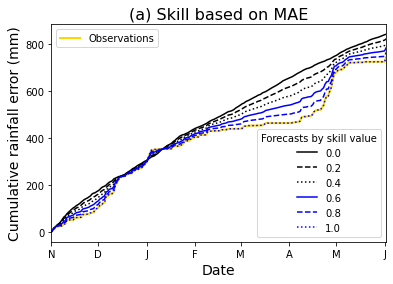

In [9]:
from src.deterministic import plot_family

# Plot MAE family
plot_family(history_file='data/hist_clim_data.csv', 
            benchmark_path='data/example/ECMWF_bias_corr_20111101.csv', 
            var_name='Rain',
            skill_name='MAE', 
            skill_specs=skill_specs, 
            destination='example_results/deterministic_family/',
            display=True
           )

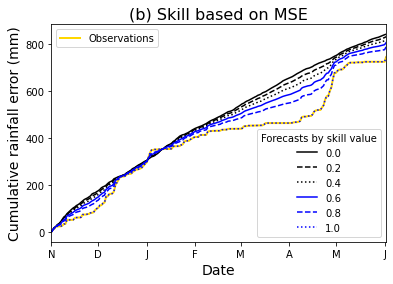

In [10]:
# Plot MSE family
plot_family(history_file='data/hist_clim_data.csv', 
            benchmark_path='data/example/ECMWF_bias_corr_20111101.csv', 
            var_name='Rain',
            skill_name='MSE', 
            skill_specs=skill_specs, 
            destination='example_results/deterministic_family/',
            display=True
           )

## Part 2: generate forecast families for ECMWF data

### Define key parameters

In [11]:
# Define data range: for instance, winter 2011-2012
begin_date = '2011/11/01'
end_date = '2012/03/01'

# List of skills to consider
skill_values = skill_specs['value'].values
print(skill_values)  # Still from 0 to 1 with 0.2 increments.

[0.  0.2 0.4 0.6 0.8 1. ]


### Import ECMWF forecast data
These are also taken from the iRONS toolbox, which also contains instructions on how to get data directly from the ECMWF website.

In [ ]:
# Folder where to store the forecast data (create it if needed)
forecast_folder = 'data/ECMWF forecasts csv/'
if os.path.exists(forecast_folder) is False:
    os.mkdir(forecast_folder)

# List dates for forecasts to pull, here with a monthly frequency
date_list = pd.date_range(start=begin_date, end=end_date, freq='MS')

# Variables
ecmwf_variables = ['Rain', 'Temp', 'Evap']
 
# Get and save forecast for all dates in range
for t in date_list:
    
    # And for all listed variables
    for w in range(len(ecmwf_variables)):
    
        # Get the data
        url = 'https://github.com/iRONStoolbox/iRONStoolbox/blob/master/iRONS/Notebooks/B%20-%20Implementation/Inputs/ECMWF%20forecasts%20csv/' + str(10000*t.year + 100*t.month + t.day) + '_1d_7m_ECMWF_' + ecmwf_variables[w] + '.csv?raw=true'
        data = pd.read_csv(url, index_col=0)
    
        # Save it
        data.to_csv(forecast_folder + str(10000*t.year + 100*t.month + t.day) + 
                    '_1d_7m_ECMWF_' + ecmwf_variables[w] + '.csv')

### Create ensemble families
With skill based on CRPSS.

In [13]:
from src.ensemble import ecmwf_ensemble_family

# Destination folder system
family_destination = 'ECMWF_families/'
if os.path.exists(family_destination) is False:
    os.mkdir(family_destination)
    
# Ensure you have the variable you want with the right name in (1) the observations, and (2) the forecasts (they can be different).
variable_names = ['Rain', 'Rain']

# Generate ensemble families
ecmwf_ensemble_family('data/hist_clim_data.csv', forecast_folder, variable_names, family_destination, skill_values, 
                      begin_date, end_date)

### Create deterministic families
With skill based either on MAE (mean absolute error) or MSE (mean squared error).

In [14]:
from src.deterministic import ecmwf_deterministic_family

# Destination folder system
if os.path.exists(family_destination + 'deterministic/') is False:
    os.mkdir(family_destination + 'deterministic/')
    
# Generate deterministic family based on MAE
ecmwf_deterministic_family('data/hist_clim_data.csv', forecast_folder, variable_names, family_destination + 
                           '/deterministic/', skill_values, begin_date, end_date, 'MAE')

# Generate deterministic family based on MSE
ecmwf_deterministic_family('data/hist_clim_data.csv', forecast_folder, variable_names, family_destination + 
                           '/deterministic/', skill_values, begin_date, end_date, 'MSE')